Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.
Classes détectées : ['01_02', '03_04', '05_06', '07_08', '09_10']

>>> Phase 1 : Entraînement des nouvelles couches...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 832ms/step - accuracy: 0.2981 - loss: 1.7440 - val_accuracy: 0.5475 - val_loss: 1.2022
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 752ms/step - accuracy: 0.4938 - loss: 1.2488 - val_accuracy: 0.5900 - val_loss: 1.0759
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 754ms/step - accuracy: 0.5931 - loss: 1.0456 - val_accuracy: 0.6025 - val_loss: 0.9938
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.6612 - loss: 0.9071 - val_accuracy: 0.6600 - val_loss: 0.9143
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.6850 - loss: 0.8266 - val_accuracy: 0.6625 - val_loss: 0.8848
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 783ms/step - accuracy: 0.7050 - loss: 0.7858 - va

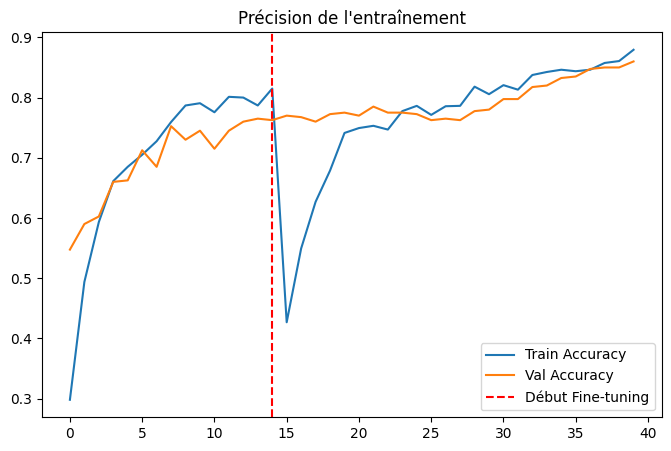

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


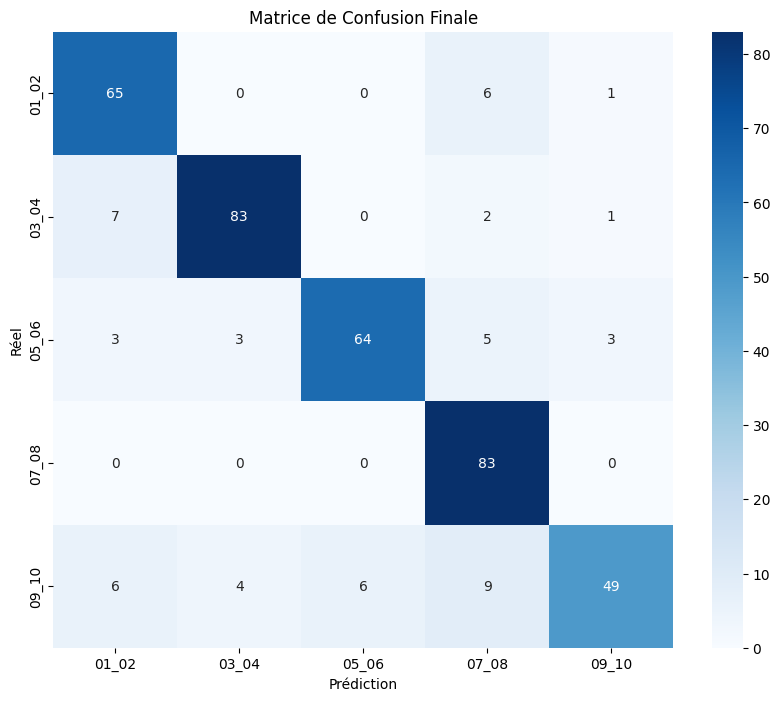


[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ============================================================
# 1. CONFIGURATION
# ============================================================
DATA_PATH = "big_dataset_lfw"  # Nom de votre dossier
IMG_SIZE = (224, 224)          # Taille optimale pour MobileNetV2
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS_PHASE1 = 15             # Entraînement de la tête
EPOCHS_PHASE2 = 25             # Fine-tuning global

# ============================================================
# 2. CHARGEMENT ET SPLIT (80% Train / 20% Test)
# ============================================================
# Chargement avec gestion automatique du split 80/20
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Classes détectées : {class_names}")

# Optimisation des performances (mémoire cache + pré-chargement)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============================================================
# 3. ARCHITECTURE DU MODÈLE (TRANSFER LEARNING)
# ============================================================
# Couche d'augmentation pour renforcer la robustesse
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Base MobileNetV2 pré-entraînée sur ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle la base au début

# Assemblage du modèle final
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input), # Normalisation auto (-1 à 1)
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),             # Protection contre l'overfitting
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# ============================================================
# 4. PHASE 1 : ENTRAÎNEMENT DE LA TÊTE (Learning Rate élevé)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n>>> Phase 1 : Entraînement des nouvelles couches...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# ============================================================
# 5. PHASE 2 : FINE-TUNING (Learning Rate très faible)
# ============================================================
# On débloque les dernières couches du modèle de base pour s'adapter aux visages
base_model.trainable = True
# On ne gèle que les premières couches (les plus génériques)
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # TRÈS IMPORTANT : LR faible
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n>>> Phase 2 : Fine-Tuning du modèle complet...")
checkpoint = callbacks.ModelCheckpoint("best_face_model.keras", save_best_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[checkpoint, reduce_lr, callbacks.EarlyStopping(patience=5)]
)

# ============================================================
# 6. ÉVALUATION ET MATRICE DE CONFUSION
# ============================================================
def plot_results(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    plt.figure(figsize=(8, 5))
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.axvline(len(h1.history['accuracy'])-1, color='red', linestyle='--', label='Début Fine-tuning')
    plt.title('Précision de l\'entraînement')
    plt.legend()
    plt.show()

plot_results(history, history_fine)

# Matrice de confusion
y_true = []
y_pred = []
for x, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion Finale')
plt.show()

print("\n[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'")

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ============================================================
# 1. SETUP ET CHARGEMENT (80% Train / 20% Test)
# ============================================================
DATA_PATH = "big_dataset_lfw" 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============================================================
# 2. DATA AUGMENTATION "FACE-SPECIFIC"
# ============================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), # Pas plus pour ne pas déformer les visages
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

# ============================================================
# 3. ARCHITECTURE DU MODÈLE
# ============================================================
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False 

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input), 
    base_model,
    layers.GlobalMaxPooling2D(), # Changé pour mieux détecter les traits saillants
    layers.Dropout(0.5),         # Augmenté pour contrer l'overfitting
    layers.Dense(5, activation='softmax')
])

# ============================================================
# 4. PHASE 1 : ENTRAÎNEMENT INITIAL (Geler la base)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Aide à la généralisation
    metrics=['accuracy']
)

print("\n>>> DÉMARRAGE PHASE 1 (Head Only)")
model.fit(train_ds, validation_data=val_ds, epochs=10)

# ============================================================
# 5. PHASE 2 : FINE-TUNING STABLE (LR très faible)
# ============================================================
# On débloque seulement les 30 dernières couches pour la précision faciale
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# IMPORTANT : On utilise un learning rate 100x plus petit pour éviter la chute de précision
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks pour un résultat parfait
my_callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
    callbacks.ModelCheckpoint("best_facial_model.keras", save_best_only=True)
]

print("\n>>> DÉMARRAGE PHASE 2 (Fine-Tuning)")
model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=my_callbacks)

print("\n[RÉSULTAT] Modèle entraîné et sauvegardé.")

Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.

>>> DÉMARRAGE PHASE 1 (Head Only)
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.2537 - loss: 6.0256 - val_accuracy: 0.3450 - val_loss: 2.8238
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 901ms/step - accuracy: 0.3425 - loss: 4.8991 - val_accuracy: 0.4350 - val_loss: 2.1669
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 876ms/step - accuracy: 0.3938 - loss: 4.0818 - val_accuracy: 0.5875 - val_loss: 1.5912
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 823ms/step - accuracy: 0.4375 - loss: 3.5645 - val_accuracy: 0.5075 - val_loss: 2.0184
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 719ms/step - accuracy: 0.4719 - loss: 3.0796 - val_accuracy: 0.6200 - val_loss: 1.4632
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 734ms/step - accuracy: 0.5256 - loss: 2.8263 - val_accuracy: 0.5675 - val_loss: 1.7410
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 731m

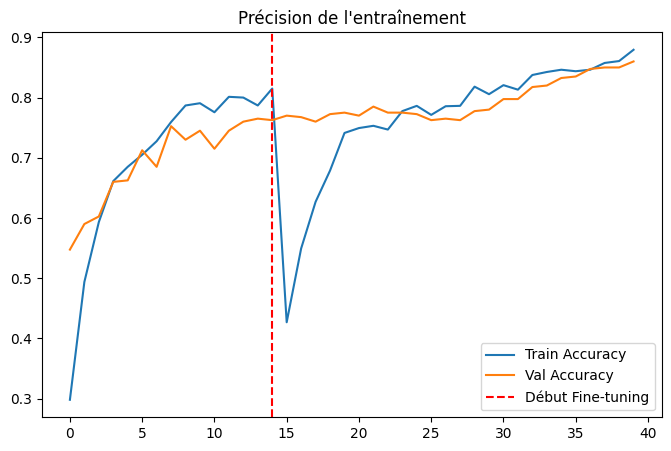

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


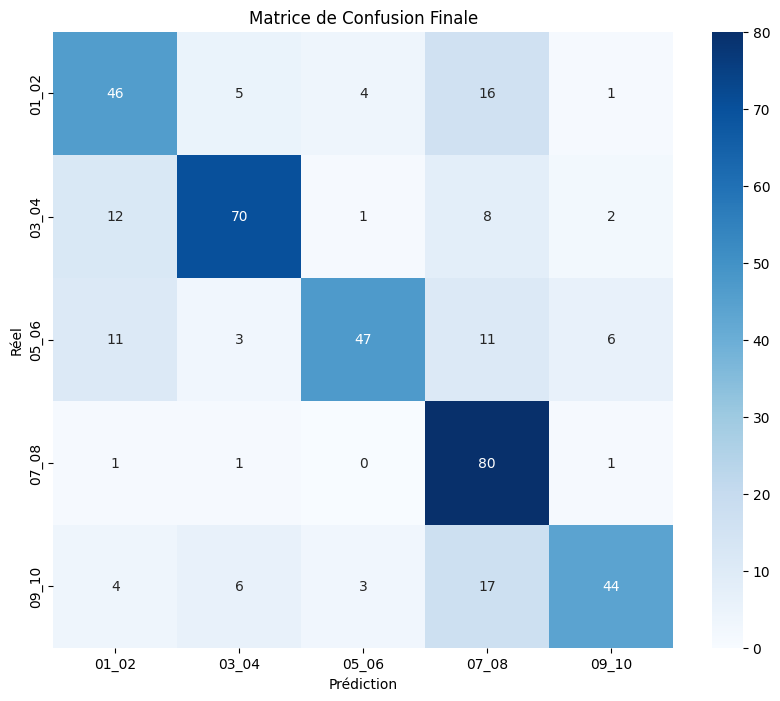


[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'


In [6]:


# ============================================================
# 6. ÉVALUATION ET MATRICE DE CONFUSION
# ============================================================
def plot_results(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    plt.figure(figsize=(8, 5))
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.axvline(len(h1.history['accuracy'])-1, color='red', linestyle='--', label='Début Fine-tuning')
    plt.title('Précision de l\'entraînement')
    plt.legend()
    plt.show()

plot_results(history, history_fine)

# Matrice de confusion
y_true = []
y_pred = []
for x, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion Finale')
plt.show()

print("\n[SUCCÈS] Modèle entraîné et sauvegardé sous 'best_face_model.keras'")

Évaluation en cours...

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

       01_02       0.62      0.64      0.63        72
       03_04       0.82      0.75      0.79        93
       05_06       0.85      0.60      0.71        78
       07_08       0.61      0.96      0.74        83
       09_10       0.81      0.59      0.69        74

    accuracy                           0.72       400
   macro avg       0.74      0.71      0.71       400
weighted avg       0.75      0.72      0.72       400



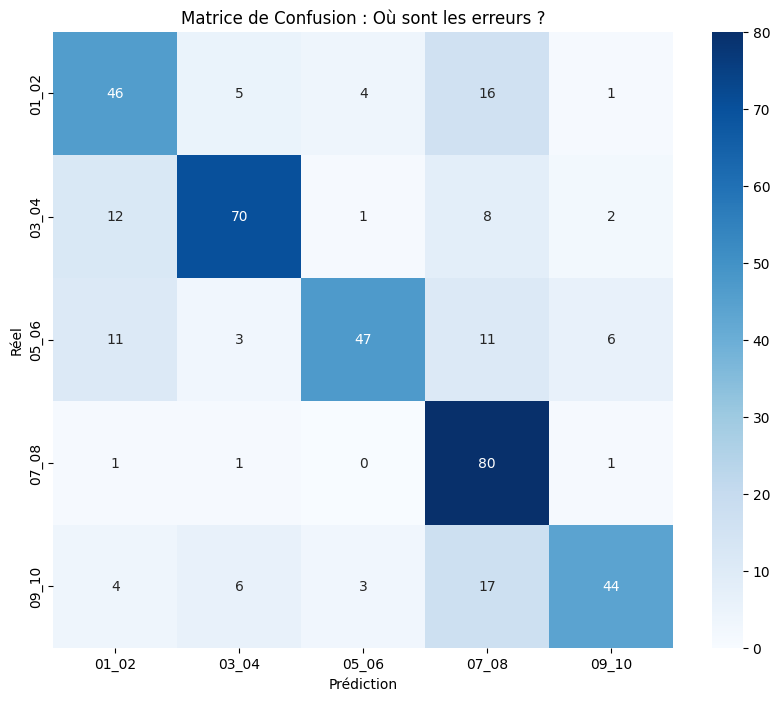

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Récupérer les vrais labels et les prédictions
y_true = []
y_pred = []

print("Évaluation en cours...")
for imgs, labels in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Afficher le rapport texte
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Matrice de confusion visuelle
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion : Où sont les erreurs ?')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

In [8]:
def predict_face(img_path, model, class_names):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Créer un batch de 1
    
    # Prétraitement et Prédiction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    class_idx = np.argmax(predictions[0])
    confidence = 100 * np.max(predictions[0])
    
    print(f"Identité : {class_names[class_idx]} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{class_names[class_idx]} - {confidence:.2f}%")
    plt.axis('off')

# Utilisation
# predict_face("chemin/vers/ta/photo.jpg", model, class_names)